# bagged_nolearn

In [1]:
from __future__      import division
from IPython.display import display
from matplotlib      import pyplot as plt
%matplotlib inline

import numpy  as np
import pandas as pd
import random, sys, os

from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search      import RandomizedSearchCV, GridSearchCV

In [2]:
SEED   = 97
scale  = True 
minmax = False
norm   = False
nointercept = True
engineering = False

max_epochs = 100
N_CLASSES  = 2

submission_filename = "../submissions/submission_bagged_nolearn.csv"

In [3]:
global early_stop_type
early_stop_type = 'unset'

In [4]:
import theano
from theano import tensor as T

import lasagne
from lasagne                import layers, nonlinearities
from lasagne.nonlinearities import rectify, softmax, sigmoid
from lasagne.updates        import nesterov_momentum, adam, adagrad, rmsprop
from lasagne.layers         import InputLayer, DenseLayer, DropoutLayer
from lasagne.layers         import get_all_params

try:
    from lasagne.layers.cuda_covnet import Conv2DCCLayer    as Conv2DLayer
    from lasagne.layers.cuda_covnet import MaxPool2DCCLayer as MaxPool2DLayer
    from lasagne.layers             import Pool2DLayer
    print("Conv2DCCLayer and MaxPool2DCCLayer used")
    DCC = True
except ImportError:
    print("ImportError: Conv2DLayer and MaxPool2DLayer used")
    DCC = False
    Conv2DLayer    = lasagne.layers.Conv2DLayer
    MaxPool2DLayer = lasagne.layers.MaxPool2DLayer
    Pool2DLayer    = lasagne.layers.Pool2DLayer

ImportError: Conv2DLayer and MaxPool2DLayer used


In [5]:
from nolearn.lasagne           import NeuralNet, TrainSplit, BatchIterator
from nolearn.lasagne           import objective
from nolearn.lasagne           import PrintLayerInfo

from nolearn.lasagne.visualize import plot_loss
from nolearn.lasagne.visualize import plot_conv_weights
from nolearn.lasagne.visualize import plot_conv_activity
from nolearn.lasagne.visualize import plot_occlusion

In [6]:
print theano.config.device

cpu


# Load the training data

In [7]:
from load_blood_data import load_blood_data

y_train, X_train = load_blood_data(train=True, SEED   = SEED, 
                                               scale  = scale,
                                               minmax = minmax,
                                               norm   = norm,
                                               nointercept = nointercept,
                                               engineering = engineering)

# Fit the model

In [8]:
"""
[Using convolutional neural nets to detect facial keypoints; Daniel Nouri]
"""

def float32(k):
    """
    Cast a variable for inclusion in a theano.shared variable
    for subsequent use by AdjustVariable
    """
    return np.cast['float32'](k)

class AdjustVariable(object):
    """
    Change the 'name' parameter each epoch
    on a linspace(start, stop) schedule
    """
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)
        
class EarlyStopping_loss(object):
    """
    Stop the training process if the validation loss has not declined
    for 'patience' epochs
    The model returned has the weights from the epoch with the lowest validation loss.
    """
    def __init__(self, patience=100):
        self.patience         = patience
        self.best_valid       = np.inf
        self.best_valid_epoch = 0
        self.best_weights     = None
        global early_stop_type
        early_stop_type = 'loss'
        

    def __call__(self, nn, train_history):
        current_valid = train_history[-1]['valid_loss']
        current_epoch = train_history[-1]['epoch']
        if current_valid < self.best_valid:
            self.best_valid = current_valid
            self.best_valid_epoch = current_epoch
            self.best_weights = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("\nEarly stopping.")
            print("Best valid loss was {:.6f} at epoch {}.\n".format(
                self.best_valid, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()
            
class EarlyStopping_acc(object):
    """
    Stop the training process if the validation accuracy has not increased
    for 'patience' epochs
    The model returned has the weights from the epoch with the highest validation accuracy.
    """
    def __init__(self, patience=100):
        self.patience         = patience
        self.best_valid_acc   = 0
        self.best_valid_epoch = 0
        self.best_weights     = None
        global early_stop_type
        early_stop_type = 'acc'
        

    def __call__(self, nn, train_history):
        global early_stop
        current_valid_acc = train_history[-1]['valid_accuracy']
        current_epoch     = train_history[-1]['epoch']
        if current_valid_acc > self.best_valid_acc:
            self.best_valid_acc   = current_valid_acc
            self.best_valid_epoch = current_epoch
            self.best_weights     = nn.get_all_params_values()
        elif self.best_valid_epoch + self.patience < current_epoch:
            print("\nEarly stopping.")
            print("Best valid accuracy was {:.6f} at epoch {}.\n".format(
                self.best_valid_acc, self.best_valid_epoch))
            nn.load_params_from(self.best_weights)
            raise StopIteration()
            
def elastic_net(layers, lambdaL1=0., lambdaL2=0., *args, **kwargs):
    losses = objective(layers, *args, **kwargs)
    # get the layers' weights, but not the biases
    weights = get_all_params(layers[-1], regularizable=True)
    # sum of absolute weights for L1
    sum_abs_weights = sum([abs(w).sum() for w in weights])
    # sum of squared weights for L2
    sum_squared_weights = sum([(w ** 2).sum() for w in weights])
    # add weights to regular loss
    losses += lambdaL1 * sum_abs_weights + lambdaL2 * sum_squared_weights
    return losses

class FlipBatchIterator(BatchIterator):

    def transform(self, Xb, yb):
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)

        # Flip half of the images in this batch at random:
        bs = Xb.shape[0]
        indices = np.random.choice(bs, bs / 2, replace=False)
        Xb[indices] = Xb[indices, :, :, ::-1]

        return Xb, yb

In [9]:
"""
[Understanding the difficulty of training deep feedforward neural networks; Xavier Glorot, Yoshua Bengio]
"""

def xavierReLU(fan_in,fan_out):
    """
    Xavier Glorot and Yohua Bengio recommended weight initialization
    for layers using a ReLU activation function
    
    W ~ U[ +/- sqrt(6 / (fan_in + fan_out)) ]
    """
    import numpy as np
    return np.sqrt(6. / (fan_in + fan_out))

def xavierTanH(fan_in,fan_out):
    """
    Xavier Glorot and Yohua Bengio recommended weight initialization
    for layers using a tanh activation function
    
    W ~ U[ +/- 4 * sqrt(6 / (fan_in + fan_out)) ]
    """
    import numpy as np
    return 4. * np.sqrt(6. / (fan_in + fan_out))

In [10]:
"""
["Bagging Predictors" Department of Statistics UC Berkeley 1994; Leo Breiman]
"""

class BaggedNolearn(object):
    """
    Runs the nolearn base estimator 'n_estimators' times, fitting with
    the X_train indices drawn from a random sample of size X_train.shape[0] 
    with replacement
    
    Usage
    -----
    clf = BaggedNolearn(base_estimator, n_estimators)
    
        base_estimator is an instance of a nolearn object
        n_estimators   is the number of bagged replicas to use
        
    clf.fit(X_train, y_train)
    
        a no-op; merely stores X_train and y_train for use in the
        predict and predict_proba methods
        
    clf.predict(X_test)
    
        the value returned is the majority vote of each of the
        fitted base_estimators' class predictions
        
    clf.predict_proba(X_test)
    
        the value returned is the average of each of the
        fitted base_estimators' probabilities
    """
    def __init__(self, base_estimator, n_estimators=11):
        from copy import copy, deepcopy
        self.n_estimators   = n_estimators
        
        # Daniel Nouri didn't give me a __copy__ method
        # ---------------------------------------------
        # see 
        # http://stackoverflow.com/questions/1500718/ \
        # what-is-the-right-way-to-override-the-copy-deepcopy-operations-on-an-object-in-p
        def shallow_copy(self):
            cls = self.__class__
            result = cls.__new__(cls)
            result.__dict__.update(self.__dict__)
            return result

        def deep_copy(self, memo):
            cls = self.__class__
            result = cls.__new__(cls)
            memo[id(self)] = result
            for k, v in self.__dict__.items():
                setattr(result, k, deepcopy(v, memo))  
            return result

        base_estimator.__copy__     = shallow_copy
        base_estimator.__deepcopy__ = deep_copy
        
        self.base_estimator = base_estimator

        
    def fit(self, X_train, y_train):
        """
        The actual fitting is done in the predict & predict_proba methods
        """
        self.X_train = X_train
        self.y_train = y_train
        
            
    def predict(self, X_test):
        """
        Return the majority vote of 'n_estimators' fits
        """
        from copy import copy, deepcopy
        predictions = []
        for i in range(self.n_estimators):
            clf = copy(self.base_estimator)
            # this is required since it isn't reset by the copy operation
            clf.train_history_ = []
            idx = np.random.choice(a    = range(self.X_train.shape[0]), 
                                   size = self.X_train.shape[0], 
                                   replace=True, p=None)

            clf.fit(self.X_train[idx,:], self.y_train[idx],epochs = max_epochs)
            predictions.append(clf.predict(X_test))
            
        from scipy.stats import mode
        
        return mode(predictions)[0][0]
    
    def predict_proba(self, X_test):
        """
        Return the average probability matrix of 'n_estimators' fits
        """
        competed_bags = 0
        from copy import copy, deepcopy
        predictions = np.empty((X_test.shape[0], N_CLASSES), dtype=np.float32)
        for i in range(self.n_estimators):
            clf = copy(self.base_estimator)
            # this is required since it isn't reset by the copy operation
            clf.train_history_ = []
            idx = np.random.choice(a    = range(self.X_train.shape[0]), 
                                   size = self.X_train.shape[0], 
                                   replace=True, p=None)
            
            clf.fit(self.X_train[idx,:], self.y_train[idx],epochs = max_epochs)
            predictions += clf.predict_proba(X_test)
            competed_bags += 1
            
        return predictions / float(competed_bags)

In [11]:
%%time
"""
[Neural Networks and Deep Learning; Michael Nielsen ]
"""

random.seed(SEED)

# ----------------------------------- base estimator -------------------------------
clf_layers=[
            ('input',    InputLayer),
    
    
#             ('dropout1', DropoutLayer),
            ('dense1',   DenseLayer),
    
#             ('dropout2', DropoutLayer),
#             ('dense2',   DenseLayer),
    

            ('output',   DenseLayer),
            ]



base = NeuralNet(
    
    layers=clf_layers,
    
    regression=False,
    
    # --------------------------------------------------------------------------
    
    input_shape=(None, X_train.shape[1]), 
    
    # Fully Connected
    # ===============
#     dropout1_p=0.20,
    
    dense1_num_units    = 500,
    dense1_nonlinearity = lasagne.nonlinearities.LeakyRectify(leakiness=1./3.),
    dense1_W = lasagne.init.Uniform(range = xavierReLU(X_train.shape[1], 500)),
    dense1_b = lasagne.init.Constant(1.),
    
#     dropout2_p=0.02,
    
#     dense2_num_units    = 10,
#     dense2_nonlinearity = lasagne.nonlinearities.LeakyRectify(leakiness=1./3.),
#     dense2_W = lasagne.init.Uniform(range = xavierReLU(500, 10)),
#     dense2_b = lasagne.init.Constant(1.),
    

    # Output
    # ======
    output_num_units    = N_CLASSES, 
    output_nonlinearity = nonlinearities.softmax,
    output_W = lasagne.init.Normal(std=1./np.sqrt(500 + N_CLASSES), mean=0.0),
    output_b = lasagne.init.Constant(1.),
    
    # --------------------------------------------------------------------------
    
    # Loss Function
    # =============
    objective_loss_function = lasagne.objectives.categorical_crossentropy,
    
    # L1 & L2 Regularization
    # ======================
    objective          = elastic_net,
    objective_lambdaL1 = 0.0000,
    objective_lambdaL2 = 0.0000,
    
    # Update Function
    # ===============
    update               = lasagne.updates.momentum,
    update_learning_rate = theano.shared(float32(0.003)),
    update_momentum      = theano.shared(float32(0.9)),
    
    # Early Stopping
    # ==============
    on_epoch_finished=[
        AdjustVariable('update_learning_rate', start=0.003,  stop=0.0003),
        AdjustVariable('update_momentum',      start=0.9,    stop=0.99),
        
        EarlyStopping_loss(patience = 50)
        ],
    
    
    # Mini-Batch Size
    # ===============
    batch_iterator_train = BatchIterator(batch_size=1), 
    batch_iterator_test  = BatchIterator(batch_size=1),

    # Max Epochs
    # ==========
    max_epochs = max_epochs,
    
    verbose=0,
    train_split=TrainSplit(0.2, stratify=True)
    )

# ----------------------------------- BaggedNolearn -------------------------------
clf = BaggedNolearn(base_estimator = base, 
                    n_estimators   = 11)



CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 19.4 ms


In [12]:
clf.fit(X_train.values.astype(np.float32)[range(X_train.shape[0]),:], y_train)

# Training set predictions

In [13]:
predicted_values = clf.predict(X_train.values.astype(np.float32))
y_true, y_pred   = y_train, predicted_values

predicted_probs  = clf.predict_proba(X_train.values.astype(np.float32))
donate_probs     = [prob[1] for prob in predicted_probs]


Early stopping.
Best valid loss was 0.462072 at epoch 39.


Early stopping.
Best valid loss was 0.462072 at epoch 39.


Early stopping.
Best valid loss was 0.462072 at epoch 39.


Early stopping.
Best valid loss was 0.419679 at epoch 36.


Early stopping.
Best valid loss was 0.419679 at epoch 36.


Early stopping.
Best valid loss was 0.419679 at epoch 36.


Early stopping.
Best valid loss was 0.419679 at epoch 36.


Early stopping.
Best valid loss was 0.381848 at epoch 30.


Early stopping.
Best valid loss was 0.381848 at epoch 30.


Early stopping.
Best valid loss was 0.381848 at epoch 30.


Early stopping.
Best valid loss was 0.381848 at epoch 30.


Early stopping.
Best valid loss was 0.381848 at epoch 30.


Early stopping.
Best valid loss was 0.381848 at epoch 30.



In [14]:
print(y_pred[:10])
print(predicted_probs[:10])
for i in range(10):
    a,b = predicted_probs[i]
    print a+b,
print
print(donate_probs[:10])

[0 0 0 0 0 0 0 0 0 0]
[[ -2.99690885e+10   3.10204148e-01]
 [  5.71282566e-01   4.28717434e-01]
 [  8.04413974e-01   1.95586056e-01]
 [  8.54075074e-01   1.45924911e-01]
 [  6.85399950e-01   3.14600080e-01]
 [  9.08846498e-01   9.11535546e-02]
 [  9.58199859e-01   4.18002121e-02]
 [  6.14263773e-01   3.85736197e-01]
 [  8.04413974e-01   1.95586056e-01]
 [  7.94321954e-01   2.05677986e-01]]
-2.99691e+10 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
[0.31020415, 0.42871743, 0.19558606, 0.14592491, 0.31460008, 0.091153555, 0.041800212, 0.3857362, 0.19558606, 0.20567799]


[[411  27]
 [ 89  49]]


/home/george/.local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


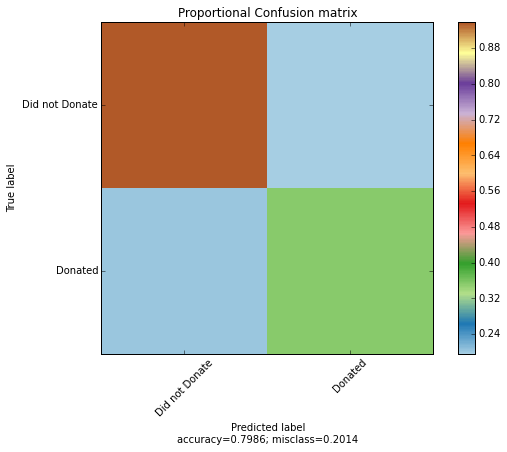

Accuracy 0.7986, mis-class rate 0.2014


In [15]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred, labels=None)
print cm

try:
    from sklearn_utilities import plot_confusion_matrix
except:
    import imp, os
    util = imp.load_source('sklearn_utilities', os.path.expanduser('~/Dropbox/Python/sklearn_utilities.py'))
    from sklearn_utilities import plot_confusion_matrix


plot_confusion_matrix(cm, ['Did not Donate','Donated'])

accuracy = round(np.trace(cm)/float(np.sum(cm)),4)
misclass = 1 - accuracy
print("Accuracy {}, mis-class rate {}".format(accuracy,misclass))

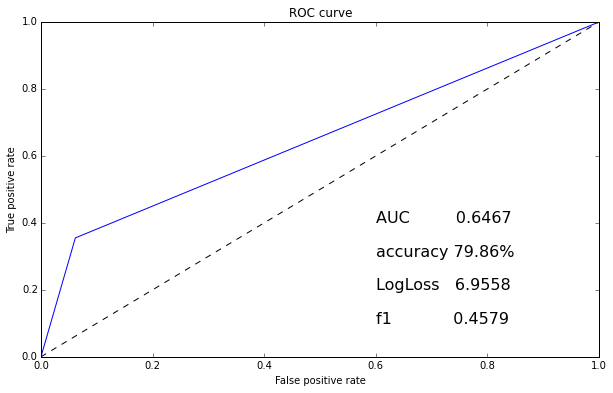

In [16]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score

fpr, tpr, thresholds = roc_curve(y_true, y_pred, pos_label=None)


plt.figure(figsize=(10,6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)

plt.text(x=0.6,y=0.4,s="AUC         {:.4f}"\
         .format(roc_auc_score(y_true, y_pred, average='macro')),
        fontsize=16)

plt.text(x=0.6,y=0.3,s="accuracy {:.2f}%"\
         .format(accuracy*100),
        fontsize=16)

plt.text(x=0.6,y=0.2,s="LogLoss   {:.4f}"\
         .format(log_loss(y_true, y_pred)),
        fontsize=16)

plt.text(x=0.6,y=0.1,s="f1            {:.4f}"\
         .format(f1_score(y_true, y_pred)),
        fontsize=16)

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

#### confirm that *sklearn.metrics.log_loss* conforms to the contest formula

In [17]:
def log_loss(y_true, y_pred):
    """
    logloss formula
    """
    import scipy
    import math
    
    assert len(y_true)==len(y_pred)
    
    n     = len(y_true)
    comps = []
    
    # prevent log(0/1): y_pred \in [epsilon, 0.999]
    epsilon = 1e-15
    y_pred = scipy.maximum(epsilon, y_pred)
    y_pred = scipy.minimum(1-epsilon, y_pred)
    
    for i in range(n):
        comp1 =    y_true[i]    * math.log(  y_pred[i],     math.e)
        comp2 = (1 - y_true[i]) * math.log((1 - y_pred[i]), math.e)
        comps.append(comp1+comp2)
    
    return round(-sum(comps)/float(n),4)

log_loss(y_true,y_pred)

6.9558

# --------------------------------------------------------------------------------------------

# Test Set Predictions

## Read the test data

In [18]:
from load_blood_data import load_blood_data

X_test, IDs = load_blood_data(train=False, SEED   = SEED, 
                                           scale  = scale,
                                           minmax = minmax,
                                           norm   = norm,
                                           nointercept = nointercept,
                                           engineering = engineering)

# Predict the test set with the fitted model

In [19]:
y_pred        = clf.predict(X_test.values.astype(np.float32))
y_pred_probs  = clf.predict_proba(X_test.values.astype(np.float32))
donate_probs  = [prob[1] for prob in y_pred_probs]

In [20]:
print(y_pred[:10])
print(y_pred_probs[:10])
for i in range(10):
    a,b = y_pred_probs[i]
    print a+b,
print
print(donate_probs[:10])

[1 0 0 0 1 1 0 0 0 0]
[[ -2.99678495e+10   5.39234579e-01]
 [ -2.99678495e+10   6.69110343e-02]
 [  7.96049654e-01   2.03950360e-01]
 [  7.07933128e-01   2.92066842e-01]
 [  3.87075335e-01   6.12924635e-01]
 [  2.72899508e-01   7.27100432e-01]
 [  7.03810930e-01   2.96189129e-01]
 [  9.29115117e-01   7.08848760e-02]
 [  9.92105305e-01   7.89463706e-03]
 [  9.50717568e-01   4.92825173e-02]]
-2.99678e+10 -2.99678e+10 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0
[0.53923458, 0.066911034, 0.20395036, 0.29206684, 0.61292464, 0.72710043, 0.29618913, 0.070884876, 0.0078946371, 0.049282517]


# Create the submission file

In [21]:
assert len(IDs)==len(donate_probs)

f = open(submission_filename, "w")

f.write(",Made Donation in March 2007\n")
for ID, prob in zip(IDs, donate_probs):
    f.write("{},{}\n".format(ID,prob))
    
f.close()